In [96]:
import imageio
from matplotlib import rcParams
import glob
import os

import colorsys
from matplotlib.colors import ColorConverter, LinearSegmentedColormap

rcParams.update({"xtick.major.pad": "7.0"})
rcParams.update({"xtick.major.size": "7.5"})
rcParams.update({"xtick.major.width": "1.5"})
rcParams.update({"xtick.minor.pad": "7.0"})
rcParams.update({"xtick.minor.size": "3.5"})
rcParams.update({"xtick.minor.width": "1.0"})
rcParams.update({"ytick.major.pad": "7.0"})
rcParams.update({"ytick.major.size": "7.5"})
rcParams.update({"ytick.major.width": "1.5"})
rcParams.update({"ytick.minor.pad": "7.0"})
rcParams.update({"ytick.minor.size": "3.5"})
rcParams.update({"ytick.minor.width": "1.0"})
rcParams.update({"font.size": 20})
rcParams.update({"xtick.top": True})
rcParams.update({"ytick.right": True})
rcParams.update({"xtick.direction": "in"})
rcParams.update({"ytick.direction": "in"})



def remove_spines(ax):
    """Remove all spines and ticks from an axis"""
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


# π-Estimator

**Monte Carlo Estimation**

Monte Carlo methods are a variety of computational techniques that involve repeatedly sampling random values to obtain numerical outcomes.
An easy example of starting with the Monte Carlo algorithm is approximating the value of π.

**Estimating π**

- Imagine a circle (radius r, centered at 0,0) inscribed in a square on a 2-D plane (side 2r, centered at 0,0).
- Add some random (x, y) points within the square and check how many fall within the circle (x² + y² ≤ 1).
- By comparing the counts of points in and out of the circle and square, we can estimate π (π ~ 4 * (circle count / square count).
- _More iterations improve accuracy_.


The math works out as follows:

- The area of the square is 2r*2r = 4r².
- The area of the circle is πr².

$$ \frac{\rm area(circle)}{\rm area(square)} = \frac{\pi r^2}{4 r^2}$$
$$ \implies \pi = 4 \frac{\rm area(circle)}{\rm area(square)} $$



## Base Implementation
Here is a simple python implementation:


First, we need to save the code in a file (we'll need this later for multiprocessing):

In [65]:
%%writefile pi_estimator.py

import random

def pi_estimation(n=100_000):
    circle_points = 0
    square_points = 0
    for i in range(n):
        rand_x = random.uniform(-1, 1)
        rand_y = random.uniform(-1, 1)
        origin_dist = rand_x ** 2 + rand_y ** 2
        if origin_dist <= 1:
            circle_points += 1
        square_points += 1
    return 4 * circle_points / square_points


Overwriting pi_estimator.py


In [75]:
import random
import numpy as np
from pi_estimator import pi_estimation

random.seed(0)


def pi_estimation_with_unc(n=100_000, n_trials=5):
    t0 = process_time()
    pi_vals = np.array([pi_estimation(n=n) for _ in range(n_trials)])
    runtime = process_time() - t0
    return np.mean(pi_vals), np.std(pi_vals), runtime

N = 10_000
n_trials = 5


pi_vals = pi_estimation_with_unc(N, n_trials)

print(f"MC Estimation of Pi (using {N:,} points, {n_trials}):\n{pi_vals[0]:.3f}+/-{pi_vals[1]:.3f}")
print(f"Runtime: {pi_vals[2]:.3f} s")

MC Estimation of Pi (using 10,000 points, 5):
3.135+/-0.012
Runtime: 0.050 s


## Implementation with multiprocessing



In [74]:
import multiprocessing as mp
from pi_estimator import pi_estimation

num_cpu = mp.cpu_count()

def parallel_pi_estimation(num_samples, num_processes):
    pool = mp.Pool(processes=num_processes)
    t0 = process_time()
    # we've unrwapped the n_trials loop into the map function call
    results = pool.map(pi_estimation, [num_samples] * num_processes)
    runtime = process_time() - t0
    pool.close()
    pool.join()
    return np.mean(results), np.std(results), runtime

pi_vals = parallel_pi_estimation(N, num_cpu)
print(f"MC Estimation of Pi (using {N:,} points, {num_cpu} trials):\n{pi_vals[0]:.3f}+/-{pi_vals[1]:.3f}")
print(f"Runtime: {pi_vals[2]:.3f} s")

MC Estimation of Pi (using 10,000 points, 12 trials):
3.140+/-0.017
Runtime: 0.008 s


## Plots of runtime

Let's plot the estimated value and runtime with different N values:

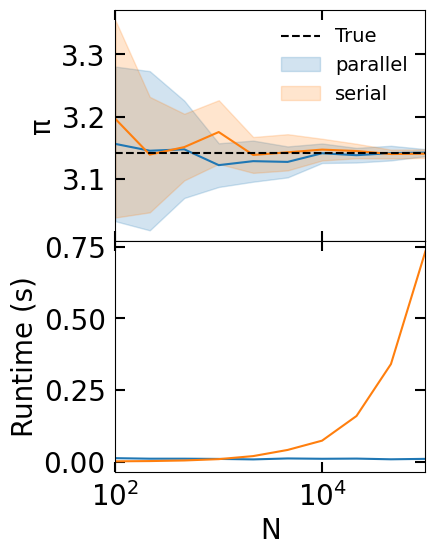

In [105]:
import matplotlib.pyplot as plt
from time import process_time
import pandas as pd




def compute_runtime_and_values(func, n_vals, n_trials):
    data = dict(
        pi=np.zeros(len(n_vals)),
        pi_unc=np.zeros(len(n_vals)),
        runtime=np.zeros(len(n_vals)),
        n_vals= n_vals,
    )

    for i, n in enumerate(n_vals):
        results = func(n, n_trials)
        data['pi'][i] = results[0]
        data['pi_unc'][i] = results[1]
        data['runtime'][i] = results[2]

    return pd.DataFrame(data)


def plot_runtimes_and_pi_value(data):
    fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    ax[0].axhline(np.pi, color='k', ls='--', zorder=10, label="True")
    for i, (label, d) in enumerate(data.items()):
        c = f"C{i}"
        ax[0].plot(d.n_vals, d.pi, color=c)
        ax[0].fill_between(n_vals, d.pi - d.pi_unc, d.pi + d.pi_unc, alpha=0.2, color=c, label=label)
        ax[1].plot(d.n_vals, d.runtime, color=c)
        ax[1].set_xlim(min(d.n_vals), max(d.n_vals))
    ax[1].set_xlabel("N")
    ax[0].set_ylabel("π")
    ax[0].legend(frameon=False, fontsize=14)
    ax[1].set_ylabel("Runtime (s)")

    ax[1].set_xscale('log')
    plt.subplots_adjust(hspace=0)
    return fig


n_vals = np.geomspace(100, 100_000, 10, dtype=int)
n_trials = 12
data = dict(
    parallel=compute_runtime_and_values(parallel_pi_estimation, n_vals, n_trials),
    serial=compute_runtime_and_values(pi_estimation_with_unc, n_vals, n_trials),
)
fig = plot_runtimes_and_pi_value(data)
fig.savefig("pi_estimation_runtimes.png", dpi=100, bbox_inches='tight')



The parallel-multiprocess runtime is doing so much better!
![](https://media.tenor.com/13nqCZN1pb4AAAAC/minion-king.gif)


Finally, lets also make a gif for fun :D

In [102]:
import numpy as np
from tqdm.auto import tqdm


def plot_pi_estimation(n=100_000):
    rand_xy = np.random.uniform(-1, 1, (n, 2))
    origin_dist = np.sum(rand_xy**2, axis=1)
    pi = 4 * np.sum(origin_dist <= 1) / n
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(rand_xy[:, 0], rand_xy[:, 1], c=origin_dist <= 1, cmap='coolwarm', s=1)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], color='tab:blue', lw=3)
    ax.plot(np.cos(theta), np.sin(theta), color='tab:red', lw=2)
    remove_spines(ax)
    ax.set_aspect('equal')
    if abs(pi - np.pi) / np.pi < 0.001:
        color = 'tab:green'
        label = "✓"
    else:
        color = 'tab:red'
        label = "✗"
    ax.text(0.1, 0.9, f"π = {pi:.3f} {label}", transform=ax.transAxes, ha='left', va='top', color=color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    fig.tight_layout(pad=0)
    return fig


def make_pi_estimation_gif(max_n=1000_000, n_frames=30, outname="pi_estimation.gif"):
    n_vals = np.geomspace(100, max_n, n_frames, dtype=int)
    with imageio.get_writer(outname, mode='I') as writer:
        for n in tqdm(n_vals, desc="Generating GIF"):
            fig = plot_pi_estimation(n)
            fig.savefig('temp.png', dpi=100)
            writer.append_data(imageio.imread_v2('temp.png'))
            plt.close(fig)
    print(f"Saved GIF to {outname}")

make_pi_estimation_gif()

Generating GIF:   0%|          | 0/30 [00:00<?, ?it/s]

Saved GIF to pi_estimation.gif


![pi_estimation.gif](pi_estimation.gif)

## Questions

1. What will happen to the speed of the multiprocessig implementation as N increases? Why?
2. What is the runtime complexity of the basic implementation? What about the multiprocessing implementation?
3. Can you think of any other ways to speed up the simulation? Plot the runtimes.
4. What will happen to the runtimes if you also add in numpy-vectorization?
5. And what about trying to do this with `Cupy`/`JAX` on a GPU?

I'll release the answers after the workshop. (Please remind me if i don't lol)

Share your plots/code/cool GIFs down below (in the website version of this page)! 😄